<a href="https://colab.research.google.com/github/mlfa19/assignments/blob/master/Module%201/m1_project/Examples/Working_with_Large_Datasets_COCO_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COCO Convnet example project
This notebook uses the GPU functionality of Pytorch and Google Collab. We need to make sure we are running our operations on the GPU, verify this in your notebook settings at the top. Setting found under:

`Runtime > Change runtime type > Hardware Accelerator -> GPU`


## Imports

In [4]:
!pip install torchviz
!pip install pycoco
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
from torchviz import make_dot
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import gdown

import matplotlib.pyplot as plt
import numpy as np # we always love numpy
import time
import json

     |████████████████████████████████| 51kB 3.9MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3520 sha256=8fb2c7a48053a8f7d925a440f31b29b4bdfa6a08cc3aacb42303cacf063fb6a8
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz
     |████████████████████████████████| 706kB 4.2MB/s 
     |████████████████████████████████| 409kB 45.0MB/s 
  Created wheel for pycoco: filename=pycoco-0.7.2-cp36-none-any.whl size=9791 sha256=51ffab15669c7b61ea999b7747ca81960d7b385f73b41d7c6c7ccf4fe2a50976
  Stored in directory: /root/.cache/pip/wheels/d5/9f/9c/6f40b261f0abad9f29cfe967547d036e4bcfa6a225e442a678
  Created wheel for ll-xist: filename=ll_xist-5.52.1-cp36-cp36m-linux_x86_64.whl size=606076 sha256=6e8b840a7568b6f8aac1d1809e5bc27f4e5bfa72a56169109f4b8682953a4a88
  Stored in directory: /root/.cache/pip/wheels/56/1b/eb/70fc69e4847c089e49f3d3b9a59beee168b602055011cc164e
Successfully buil

Now let's get the dataset we want to work with:  [COCO!](http://cocodataset.org/#detection-2017)

This is a biiiig dataset, so it's gonna be a lot of data. We have uploaded the dataset to Google Drive and will be downloading it via shared link. Google Colab is capable of downloading from Google Drive links at a very fast rate (~200 MB/sec).  We recommend this as a method of uploading large datasets.  We have a Google Drive account with lots of storage, so if you are not able to add a database to your account (due to limitations), we can add it to ours and give you a link.

In [5]:
gdown.download('https://drive.google.com/uc?authuser=0&id=1M3doqupItS419I6z-D3rCHUaPo93HbUE&export=download',
               'train2017.zip',
               quiet=False)

gdown.download('https://drive.google.com/uc?authuser=0&id=19-0acEBHMn7LOoT0CUw_ExoLkQiWnfsw&export=download',
               'val2017.zip',
               quiet=False)

gdown.download('https://drive.google.com/uc?authuser=0&id=1D_xHd_WlZTrvA2tA1D_Io8ezTSoIYEpq&export=download',
               'annotations_trainval2017.zip',
               quiet=False)

print("Dataset downloaded")

!unzip -qq -o annotations_trainval2017.zip
print("Annotations extracted")

!unzip -qq -o train2017.zip
print("training data extracted")

!unzip -qq -o val2017.zip
print("validation data extracted")

Downloading...
From: https://drive.google.com/uc?authuser=0&id=1M3doqupItS419I6z-D3rCHUaPo93HbUE&export=download
To: /content/train2017.zip
19.3GB [02:12, 146MB/s]
Downloading...
From: https://drive.google.com/uc?authuser=0&id=19-0acEBHMn7LOoT0CUw_ExoLkQiWnfsw&export=download
To: /content/val2017.zip
816MB [00:06, 118MB/s]
Downloading...
From: https://drive.google.com/uc?authuser=0&id=1D_xHd_WlZTrvA2tA1D_Io8ezTSoIYEpq&export=download
To: /content/annotations_trainval2017.zip
253MB [00:01, 148MB/s]


Dataset downloaded
Annotations extracted
training data extracted
validation data extracted


## Load the data
This dataset happens to be included with pytorch so we can call some pytorch functions to automatically load and parse the data we need to. 

This dataset has 80 classes that we're interested in. More importantly, more than one class can appear in a single image. So, we cannot rely on our typical loss function that assumes one answer per image.

Also, the images in this dataset are large, on the order of 480 x 640 pixels. We learned (through trial and error) that google colab cannot really handle images this large, so we're going to shrink them to 120 x 160 for this model.

In [0]:
# Data set information
image_dims = 3, 120, 160
n_training_samples = 100000 # How many training images to use
n_test_samples = 5000 # How many test images to use

# Read the class labels from a file
with open('./annotations/instances_val2017.json','r') as COCO:
    js = json.loads(COCO.read())
    class_list = js['categories']

# We convert the total class IDs (91) to the IDs we're interested in (80)
classes_dict = {}
classes = []
class_index = 0
for d in class_list:
  classes_dict[d['id']] = class_index
  classes.append(d['name'])
  class_index += 1
class_len = len(classes)

# Define a function to parse a sample label into a form that we want (aka a tensor)
def get_classes(target):
  class_tensor = torch.zeros((class_len))
  for c in target:
    class_id = c['category_id']
    if class_id not in classes_dict:
      continue
    idx = classes_dict[class_id]
    class_tensor[idx] = 1
  return class_tensor


In [7]:
# Define a function to transform our image into a form we can handle
# First we crop the image at the center to make sure theyre all the same size
# Then we squish it in to our desired size to make it more manageable
# transforms.ToTensor() converts our PILImage to a tensor of shape (C x H x W) in the range [0,1]
transform = transforms.Compose(
    [transforms.CenterCrop((480,640)), transforms.Resize((120,160)), transforms.ToTensor()])

print("loading training set")

# Load the training and test set
train_set = torchvision.datasets.CocoDetection(
    root='./train2017', annFile="./annotations/instances_train2017.json", transform=transform, target_transform=get_classes)
train_sampler = SubsetRandomSampler(
    np.arange(n_training_samples, dtype=np.int64))
print("loading test set")


test_set = torchvision.datasets.CocoDetection(
    root='./val2017', annFile="./annotations/instances_val2017.json", transform=transform, target_transform=get_classes)
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))


loading training set
loading annotations into memory...
Done (t=19.53s)
creating index...
index created!
loading test set
loading annotations into memory...
Done (t=0.55s)
creating index...
index created!


# Explore the data
Let's take a look at some images and their labels to make sure it makes sense.

[[ 0]
 [37]]


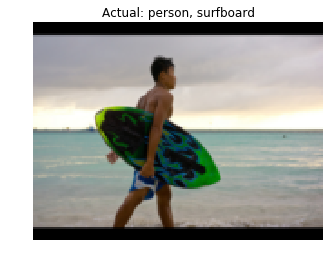

In [8]:
def disp_image(image, class_idxs, predicted=None):
    # need to reorder the tensor dimensions to work properly with imshow
    plt.imshow(image.transpose(0,2).transpose(0,1))
    plt.axis('off')
    classes_title = [classes[class_idx[0]] for class_idx in class_idxs]
    classes_title = ', '.join(classes_title)

    if predicted:
        p_classes_title = [classes[class_idx[0]] for class_idx in predicted]
        p_classes_title = ', '.join(classes_title)
        plt.title("Actual: " + classes_title + "     Predicted: " + p_classes_title)
    else:
        plt.title("Actual: " + classes_title)
    plt.show()
    
x, y = train_set[3456]
y = y.numpy()
y = np.argwhere(y == np.amax(y))
print(y)
disp_image(x, y)

## Define Model Class
Since this is a more complicated dataset than the ones we've seen in the past, we'll need a bigger model. Let's add 4 convolutional layers and expand the size of our fully connected layer.

In [0]:
class myCNN(nn.Module):
    def __init__(self):
        super(myCNN, self).__init__()
        self.activation_func = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.pool5 = nn.MaxPool2d(kernel_size=5, stride=5, padding=0)
        self.fc1_size = 256
        self.fc2_size = class_len
        # Convolutional Layers
        self.conv1 = nn.Conv2d(image_dims[0], 32, kernel_size=3,
                  stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3,
          stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3,
          stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3,
          stride=1, padding=1)
        self.maxpool_output_size = int(256 * (image_dims[1] / 40) * (image_dims[2] / 40))
        # Fully Connected Layers
        self.fc1 = nn.Linear(self.maxpool_output_size, self.fc1_size)
        self.fc2 = nn.Linear(self.fc1_size, self.fc2_size)
        
    def forward(self, x):
        # Convolutional Layers
        x = self.activation_func(self.pool2(self.conv1(x)))
        x = self.activation_func(self.pool2(self.conv2(x)))
        x = self.activation_func(self.pool2(self.conv3(x)))
        x = self.activation_func(self.pool5(self.conv4(x)))
        # Fully Connected Layers
        x = x.view(-1, self.maxpool_output_size)
        x = self.fc1(x)
        x = self.activation_func(x)
        x = self.fc2(x)
        return x

    def get_loss(self, learning_rate):
      # Loss function, we'll use BCE or Binary CrossEntropy that does not assume one class fer example
      # https://pytorch.org/docs/stable/nn.html
      loss = nn.BCEWithLogitsLoss()
      # Optimizer, self.parameters() returns all the Pytorch operations that are attributes of the class
      optimizer = optim.Adam(self.parameters(), lr=learning_rate)
      return loss, optimizer

## Training
First let's create our model. Let's also check out a graphical representation of our model (using a library we downloaded earlier) to validate the model looks like we think it should.

**Running the below cell will override your model if have already trained one**

Downloading...
From: https://drive.google.com/uc?authuser=0&id=1AUM8t698p6JIFaH-Awg_8lATuwArRzN0&export=download
To: /content/coco_pretrained.pth
9.59MB [00:00, 99.4MB/s]


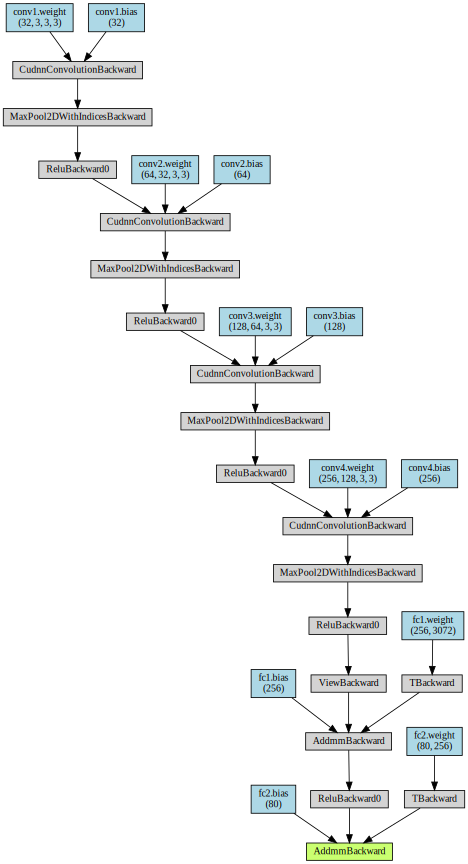

In [34]:
use_pretrained_model = True

# Define what device we want to use
device = 'cuda' # 'cpu' if we want to not use the gpu
# Initialize the model, loss, and optimization function
net = myCNN()

if use_pretrained_model:
    gdown.download('https://drive.google.com/uc?authuser=0&id=1AUM8t698p6JIFaH-Awg_8lATuwArRzN0&export=download',
                   'coco_pretrained.pth',
                   quiet=False)
    check_point = torch.load('coco_pretrained.pth')
    net.load_state_dict(check_point['state_dict'])

# This tells our model to send all of the tensors and operations to the GPU (or keep them at the CPU if we're not using GPU)
net.to(device)

# Visualize the architecture of the model
# We need to give the net a fake input for this library to visualize the architecture
fake_input = Variable(torch.zeros((1,image_dims[0], image_dims[1], image_dims[2]))).to(device)
outputs = net(fake_input)
# Plot the DAG (Directed Acyclic Graph) of the model
make_dot(outputs, dict(net.named_parameters()))

In [35]:
if not use_pretrained_model:
    # Define training parameters
    batch_size = 32
    learning_rate = 3e-3
    n_epochs = 8
    # Get our data into the mini batch size that we defined
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                            sampler=train_sampler, num_workers=2)
    test_loader = torch.utils.data.DataLoader(
        test_set, batch_size=2, sampler=test_sampler, num_workers=2)
    #loss, optimizer = net.get_loss(learning_rate)

    # Define some parameters to keep track of metrics
    print_every = 20
    test_every = 200
    idx = 0
    train_hist_x = []
    train_loss_hist = []
    test_hist_x = []
    test_loss_hist = []
else:
    print("skipping training definitions since we are using pretrained model")

# Get the brute accuracy of our model
# This doesn't really do a good job of characterizing the performance as it is the
# raw accuracy (which includes predicting 0 versus 1 for each class)
def get_acc(output,targets):
    # Get the guess of each class
    output = torch.round(torch.sigmoid(output))
    # Compare guesses
    diff = targets - output
    avg = torch.mean(torch.abs(diff))
    return 1 - avg


skipping training definitions since we are using pretrained model


### Now let's train the model!
This may take a while (2+ hours), so don't let your computer go to sleep or it may time out.

In [38]:
def test_loss(run_idx):
    # do a pass on the test set
    total_test_loss = 0
    total_acc_loss = 0
    idx = 0
    for inputs, labels in test_loader:

        # Wrap tensors in Variables
        inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

        # Forward pass
        test_outputs = net(inputs)
        test_loss_size = loss(test_outputs, labels)
        total_test_loss += test_loss_size.data.item()
        total_acc_loss += get_acc(test_outputs, labels)
        if idx >= 100:
          break
        idx += 1
    test_loss_hist.append(total_test_loss / (idx+1))
    test_hist_x.append(run_idx)
    print("Validation loss = {:.4f}".format(
        total_test_loss / (idx+1)))
    print("Validation Accuracy = {:.4f}".format(
        total_acc_loss / (idx+1)))

if not use_pretrained_model:
    training_start_time = time.time()
    # Loop for n_epochs
    for epoch in range(n_epochs):
        running_loss = 0.0
        start_time = time.time()

        for i, data in enumerate(train_loader, 0):

            # Get inputs in right form
            inputs, labels = data
            inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)
            
            # In Pytorch, We need to always remember to set the optimizer gradients to 0 before we recompute the new gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = net(inputs)
            
            # Compute the loss and find the loss with respect to each parameter of the model
            loss_size = loss(outputs, labels)
            loss_size.backward()
            
            # Change each parameter with respect to the recently computed loss.
            optimizer.step()

            # Update statistics
            running_loss += loss_size.data.item()
            
            # Print every 20th batch of an epoch
            if (i % print_every) == print_every-1:
                print("Epoch {}, Iteration {}\t train_loss: {:.4f} took: {:.4f}s".format(
                    epoch + 1, i+1,running_loss / print_every, time.time() - start_time))
                # Reset running loss and time
                train_loss_hist.append(running_loss / print_every)
                train_hist_x.append(idx)
                running_loss = 0.0
                start_time = time.time()
            # Check test set every nth batch
            if (i % test_every) == test_every -1:
                test_loss(idx)
                
                idx += 1


    print("Training finished, took {:.2f}s".format(
        time.time() - training_start_time))
else:
    print("skipping training since we are using pretrained model")

skipping training since we are using pretrained model


In [39]:
if not use_pretrained_model:
    # loading and saving via this link:
    # https://medium.com/udacity-pytorch-challengers/saving-loading-your-model-in-pytorch-741b80daf3c
    checkpoint = {'model': myCNN(),
            'state_dict': net.state_dict(),
            'optimizer' : optimizer.state_dict()
            }
    f = open('coco_pretrained.pth', 'wb')
    torch.save(checkpoint, f)
    f.close()
    from google.colab import files
    files.download('coco_pretrained.pth')
else:
    print("skipping downloading model since we are using pretrained model")

skipping downloading model since we are using pretrained model


## Testing
Let's plot the loss of the network over time to see if any learning actually occured.

In [40]:
if not use_pretrained_model:
    plt.plot(train_hist_x,train_loss_hist)
    plt.plot(test_hist_x,test_loss_hist)
    plt.show()
else:
    print("skipping showing error plots since we are using pretrained model")

skipping showing error plots since we are using pretrained model


## Visualization
Now that we have a trianed model, let's see if we can get some insights out of it.  

In this case we examined gradients of different classes with respect to the **inputs** of the model. One way to think about this, if we set the gradient of the output of class `plane` to 1, what pixels played the biggest part in the prediction of that class? AKA what pixels does the Model pay the most attention to when predicting `plane`?

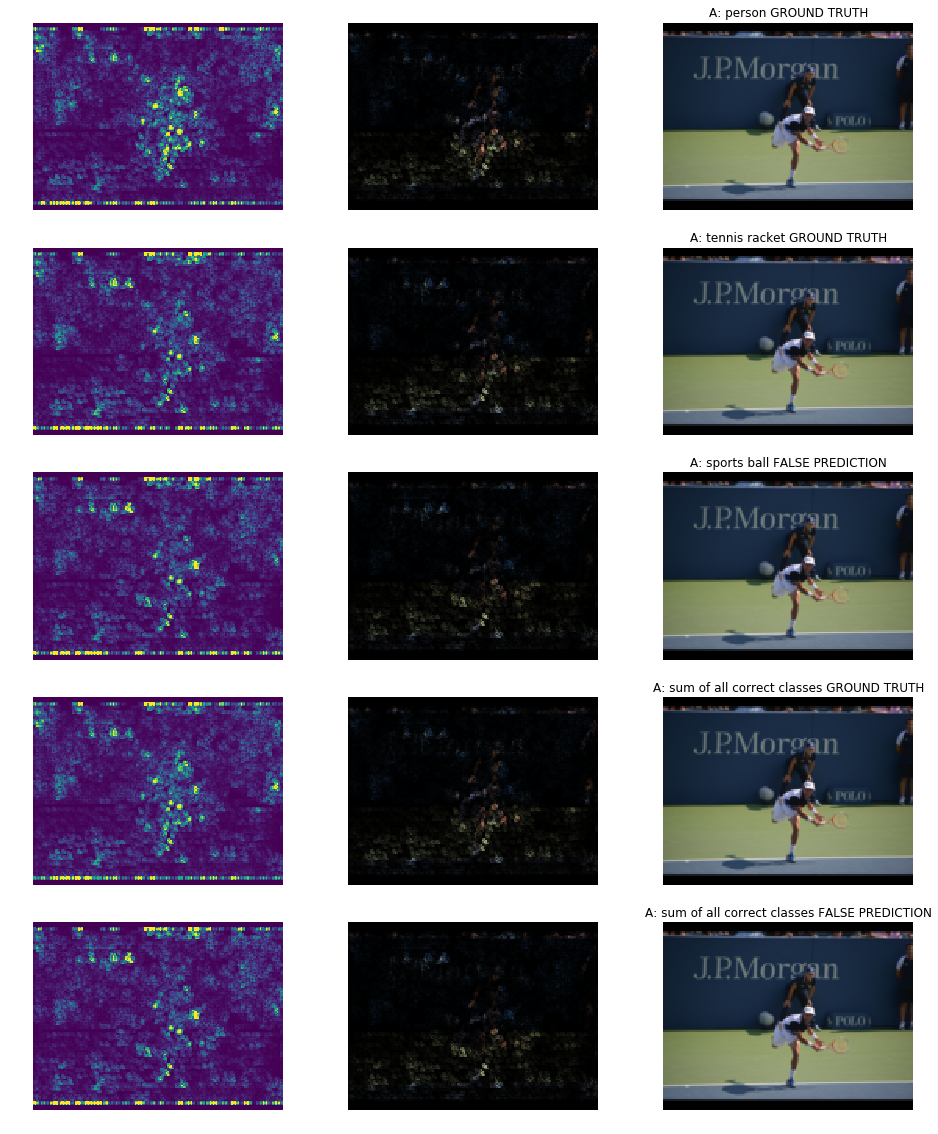

In [48]:
global input_gradients
# Used to grab the gradient
def set_gradient_hook(grad):
    global input_gradients
    input_gradients = grad

# Show an image on a given subplot
def disp_image(image, subplot, label=None, cmap='viridis', correct=True):
    plt.subplot(subplot[0], subplot[1], subplot[2])
    if(cmap != 'viridis'):  
        plt.imshow(image, cmap=cmap,vmin=0, vmax=1)
    else:
        plt.imshow(image, cmap=cmap)
    plt.axis('off')
    truth_phrase = ' GROUND TRUTH' if correct else ' FALSE PREDICTION'
    if(label is not None):
      plt.title("A: " + label + truth_phrase)

# Function that computes the relevant gradient
def get_input_gradient(image, label):
    input_img = Variable(image.unsqueeze(0), requires_grad=True).to(device)
    input_img.register_hook(set_gradient_hook)
    model_output = net(input_img)
    one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_().to(device)
    one_hot_output[0][label] = 1
    model_output.backward(gradient=one_hot_output)
    grad = np.abs(input_gradients.cpu().numpy()).squeeze()
    # Normalize Heatmap
    grayscale_im = np.sum(grad, axis=0)
    im_max = np.percentile(grayscale_im, 99)
    im_min = np.min(grayscale_im)
    grayscale_im = (np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1))
    return grayscale_im

# Plot the image, its gradients and the product of the 2 for visualization
def plot_image_row(image, grayscale, label, subplot, correct=True):
    # 1
    disp_image(grayscale, subplot)
    subplot[2] += 1
    # 2
    masked_img = np.copy(image.transpose(0,2).transpose(0,1).numpy())
    # Sqrt makes the images easier to see
    masked_img[:,:,0] = masked_img[:,:,0] * grayscale
    masked_img[:,:,1] = masked_img[:,:,1] * grayscale
    masked_img[:,:,2] = masked_img[:,:,2] * grayscale
    disp_image(masked_img, subplot)
    subplot[2] += 1
    # 3
    if label == -1:
        class_label = "sum of all correct classes"
    else:
        class_label = classes[label]
    disp_image(image.transpose(0,2).transpose(0,1), subplot, class_label, correct=correct)
    subplot[2] += 1
    return subplot

# Plot the gradients and image for every correct class for an image, also plot any incorrect guesses if applicable
def analyse_image(idx):
    image, label = test_set[idx]
    logits = net(Variable(image.unsqueeze(0)).to(device)).squeeze()
    correct_classes = [idx for idx, val in enumerate(label) if val == 1]
    incorrect_classes = [idx for idx, val in enumerate(logits) if (val >= 0 and idx not in correct_classes)]
    num_plots = len(correct_classes) + len(incorrect_classes) + bool(correct_classes) + bool(incorrect_classes)
    plt.figure(figsize=(16,4 * (num_plots)))
    subplot = [num_plots, 3, 1]
    # Correct
    correct_grayscales = []
    for idx in correct_classes:
        grayscale_correct = get_input_gradient(image, idx)
        correct_grayscales.append(grayscale_correct)
        subplot = plot_image_row(image, grayscale_correct, idx, subplot)
    # Incorrect
    incorrect_grayscales = []
    for idx in incorrect_classes:
        grayscale_incorrect = get_input_gradient(image, idx)
        incorrect_grayscales.append(grayscale_incorrect)
        subplot = plot_image_row(image, grayscale_incorrect, idx, subplot, False)
    if(len(correct_classes)):
        correct_grayscales = np.array(correct_grayscales)
        correct_grayscales = correct_grayscales.mean(axis=0)
        subplot = plot_image_row(image, correct_grayscales, -1, subplot)
    if(len(incorrect_classes)):
        incorrect_grayscales = np.array(incorrect_grayscales)
        incorrect_grayscales = incorrect_grayscales.mean(axis=0)
        subplot = plot_image_row(image, incorrect_grayscales, -1, subplot, False)

    plt.show()

analyse_image(8)


## Extensions
We chose to look into the input visualizations of this model, but there are many other sample directions we could have gone. We could:

- Change the structure of the network to improve the fit to data
- Add some regularization on the model to prevent overfitting (such as penalizing the square of the weights as we did in ridge regression or using a special technique for neural networks called [Dropout](https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5))
- Try instead to use simple logistic regression on the data and see how your results look in comparison
- Test the trained model on another dataset to see how much knowledge transfers over
- Do some form of visualization on the weights of the model
- Try this visualization on a pre-trained model, such as Inception
